In [24]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import sys
sys.path.insert(0, "../src/")
import importlib
from util import ipca
from sklearn.metrics import r2_score
importlib.reload(ipca)

<module 'util.ipca' from '/Users/jandh/Desktop/Old Desktop/od/2 Quarter/Flexible/Factor-Research/notebooks/../src/util/ipca.py'>

In [25]:
crsp_features = pd.read_csv("../data/ipca_features_final.csv")
crsp_features.head()

,Unnamed: 0.1,Unnamed: 0,cusip,permno,permco,issuno,hexcd,hsiccd,date,bidlo,...,gvkey,revtq,niq,atq,epsfxq,cheq,dlttq,cogsq,oibdpq,cshoq
0,0,0,02742010,60409,20092,0,2,7392.0,1990-01-31,0.25000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,02742010,60409,20092,0,2,7392.0,1990-02-28,0.25000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,02742010,60409,20092,0,2,7392.0,1990-03-30,-0.28125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,02742010,60409,20092,0,2,7392.0,1990-04-30,0.25000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,02742010,60409,20092,0,2,7392.0,1990-05-31,0.18750,...,1506.0,5.126,0.017,4.172,0.0,0.0,0.0,3.133,0.084,12.737


In [26]:
filepath = '/Users/jandh/Desktop/Old Desktop/od/2 Quarter/Flexible/snp1500.txt'
with open(filepath, 'r') as f:
        tickers = [line.strip() for line in f]

In [27]:
snp_ticker_df = pd.DataFrame(crsp_features.groupby('permno')['ticker'].apply(lambda x: x.iloc[-1]),columns=['ticker'])
snp_ticker_df = snp_ticker_df[snp_ticker_df['ticker'].isin(tickers)]
snp_ticker_df

,ticker
permno,
10026,JJSF
10032,PLXS
10057,AMT
10097,FIX
10104,ORCL
...,...
93356,SPSC
93374,FAF
93427,FN


In [28]:
crsp_features['date'] = pd.to_datetime(crsp_features['date'] )

In [29]:
crsp_features.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'cusip', 'permno', 'permco', 'issuno',
       'hexcd', 'hsiccd', 'date', 'bidlo', 'askhi', 'prc', 'vol', 'ret', 'bid',
       'ask', 'shrout', 'cfacpr', 'cfacshr', 'altprc', 'spread', 'altprcdt',
       'retx', 'date.1', 'vwretd', 'vwretx', 'ewretd', 'ewretx', 'sprtrn',
       'spindx', 'totval', 'totcnt', 'usdval', 'usdcnt', 'ticker', 'mktcap',
       'turnover', 'adjprc', 'momentum', 'short_term_reversal',
       'long_term_reversal', '52wk_high', 'price_rel_52wk_high', 'rf', 'beta',
       'idvol', 'unexp_vol', 'gvkey', 'revtq', 'niq', 'atq', 'epsfxq', 'cheq',
       'dlttq', 'cogsq', 'oibdpq', 'cshoq'],
      dtype='object')

## Test Train Split (TS Test) 

In [30]:
# all_stocks = pd.Series(crsp_features['permno'].unique())
# all_stocks_eos = crsp_features[crsp_features['date']==pd.to_datetime('2024-12-31')]['permno']
# test_stocks = all_stocks_eos.sample(int(len(all_stocks_eos)*0.2),random_state=27)
# train_stocks = all_stocks[~all_stocks.isin(test_stocks)]
# print(f"Length of train stocks {len(train_stocks)}")
# print(f"Length of test stocks {len(test_stocks)}")

test_date_start = pd.to_datetime("2018-01-01")

In [31]:
crsp_features['mkt_to_book'] = crsp_features['mktcap']/crsp_features['atq']

In [32]:
y_column = ['ret']
x_columns = ['vol','beta','mktcap','momentum','short_term_reversal','52wk_high','price_rel_52wk_high','idvol','unexp_vol','turnover','mkt_to_book','revtq', 'niq', 'atq', 'epsfxq', 'cheq',
       'dlttq', 'cogsq', 'oibdpq', 'cshoq']
crsp_features = crsp_features[x_columns+y_column+['date','permno']]

In [33]:
fund_features = ['revtq', 'niq', 'atq', 'epsfxq', 'cheq',
       'dlttq', 'cogsq', 'oibdpq', 'cshoq']


In [34]:
def rankNormalize(group):
    # Get all columns
    all_columns = list(group.columns)
    
    # Identify columns to exclude from normalization
    exclude_columns = ['permno', 'date','ret']
    
    # Get columns to normalize
    columns_to_normalize = [col for col in all_columns if col not in exclude_columns]
    
    # Create a copy of the original dataframe
    result = group.copy()
    
    # Apply rank normalization only to the columns that need it
    result[columns_to_normalize] = (
        group[columns_to_normalize].rank(axis=0, method='average') / 
        (group[columns_to_normalize].count())
    ) - 0.5
    
    # Return the dataframe with all columns
    return result

In [35]:
result = crsp_features.groupby('date').apply(rankNormalize).reset_index(level=0, drop=True)

/var/folders/vf/gw1t6f4j3mv84kp8kpw4j_bw0000gn/T/ipykernel_4580/2380117743.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = crsp_features.groupby('date').apply(rankNormalize).reset_index(level=0, drop=True)


In [36]:
result.head()

,vol,beta,mktcap,momentum,short_term_reversal,52wk_high,price_rel_52wk_high,idvol,unexp_vol,turnover,...,atq,epsfxq,cheq,dlttq,cogsq,oibdpq,cshoq,ret,date,permno
0,-0.260891,NaN,-0.368812,NaN,NaN,NaN,NaN,NaN,NaN,-0.421287,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.166667,1990-01-31,60409
391,0.485149,NaN,0.437129,NaN,0.061848,NaN,NaN,NaN,NaN,0.447525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.157667,1990-01-31,24643
866,0.405198,NaN,-0.018812,NaN,-0.253105,NaN,NaN,NaN,NaN,0.403960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.058824,1990-01-31,64151
1438,0.325248,NaN,0.002475,NaN,-0.456284,NaN,NaN,NaN,NaN,0.429208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.128527,1990-01-31,14403
1795,0.319802,NaN,0.179703,NaN,-0.161451,NaN,NaN,NaN,NaN,0.179208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.171429,1990-01-31,63845


In [37]:
def get_nan_count(return_series):
        return return_series.isna().sum()
result.groupby('permno')['revtq'].apply(get_nan_count)

permno
10001      0
10002    129
10009    128
10011      0
10012      3
        ... 
93431      0
93432      2
93433      0
93434      2
93436      2
Name: revtq, Length: 13092, dtype: int64

# Lag the returns

In [38]:
result[result.permno==21726].head()

,vol,beta,mktcap,momentum,short_term_reversal,52wk_high,price_rel_52wk_high,idvol,unexp_vol,turnover,...,atq,epsfxq,cheq,dlttq,cogsq,oibdpq,cshoq,ret,date,permno
243008,0.015594,0.365169,0.092574,-0.363636,-0.239195,0.406977,-0.093023,-0.095506,-0.106742,0.191584,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.150000,1990-01-31,21726
243009,-0.132477,0.357143,0.092190,-0.366667,0.325137,0.385057,-0.143678,-0.093407,-0.137363,-0.102076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.061765,1990-02-28,21726
243010,-0.247535,0.326087,0.091716,-0.377778,-0.252105,0.383721,-0.081395,-0.130435,-0.152174,-0.277613,...,0.014563,0.108040,-0.135922,-0.124390,0.014706,0.077143,-0.133333,0.000000,1990-03-30,21726
243011,-0.183154,0.338710,0.102156,-0.377778,0.099409,0.362069,-0.051724,-0.102151,-0.102151,-0.179726,...,0.052561,0.151685,-0.109164,-0.088556,0.060647,0.098160,-0.126316,0.063380,1990-04-30,21726
243012,-0.191687,0.434066,0.103229,-0.181818,-0.355698,0.311765,-0.041176,-0.104396,-0.192308,-0.187531,...,-0.041950,0.096389,-0.178015,-0.162837,0.018328,0.015982,-0.139053,0.074172,1990-05-31,21726


In [39]:
def lag_returns(group):
    return group['ret'].shift(-1)


result['lagged_ret'] = result.groupby('permno').apply(lag_returns).reset_index(level=0, drop=True)


/var/folders/vf/gw1t6f4j3mv84kp8kpw4j_bw0000gn/T/ipykernel_4580/1478322671.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result['lagged_ret'] = result.groupby('permno').apply(lag_returns).reset_index(level=0, drop=True)


In [40]:
result[result.permno==21726].head()


,vol,beta,mktcap,momentum,short_term_reversal,52wk_high,price_rel_52wk_high,idvol,unexp_vol,turnover,...,epsfxq,cheq,dlttq,cogsq,oibdpq,cshoq,ret,date,permno,lagged_ret
243008,0.015594,0.365169,0.092574,-0.363636,-0.239195,0.406977,-0.093023,-0.095506,-0.106742,0.191584,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.150000,1990-01-31,21726,0.061765
243009,-0.132477,0.357143,0.092190,-0.366667,0.325137,0.385057,-0.143678,-0.093407,-0.137363,-0.102076,...,NaN,NaN,NaN,NaN,NaN,NaN,0.061765,1990-02-28,21726,0.000000
243010,-0.247535,0.326087,0.091716,-0.377778,-0.252105,0.383721,-0.081395,-0.130435,-0.152174,-0.277613,...,0.108040,-0.135922,-0.124390,0.014706,0.077143,-0.133333,0.000000,1990-03-30,21726,0.063380
243011,-0.183154,0.338710,0.102156,-0.377778,0.099409,0.362069,-0.051724,-0.102151,-0.102151,-0.179726,...,0.151685,-0.109164,-0.088556,0.060647,0.098160,-0.126316,0.063380,1990-04-30,21726,0.074172
243012,-0.191687,0.434066,0.103229,-0.181818,-0.355698,0.311765,-0.041176,-0.104396,-0.192308,-0.187531,...,0.096389,-0.178015,-0.162837,0.018328,0.015982,-0.139053,0.074172,1990-05-31,21726,-0.043478


In [41]:
result.drop(columns=['ret'],inplace=True)
# result = result.rename(columns={''})
y_column = ['lagged_ret']

In [42]:
result = result[~np.any(np.isnan(result), axis=1)]

In [43]:
len(result)

1045202

In [44]:
crsp_features = result.set_index(["permno", "date"])
crsp_features.head()

,,vol,beta,mktcap,momentum,short_term_reversal,52wk_high,price_rel_52wk_high,idvol,unexp_vol,turnover,...,revtq,niq,atq,epsfxq,cheq,dlttq,cogsq,oibdpq,cshoq,lagged_ret
permno,date,,,,,,,,,,,,,,,,,,,,,
21726,1990-03-30,-0.247535,0.326087,0.091716,-0.377778,-0.252105,0.383721,-0.081395,-0.130435,-0.152174,-0.277613,...,0.004854,0.095122,0.014563,0.108040,-0.135922,-0.124390,0.014706,0.077143,-0.133333,0.063380
11641,1990-03-30,0.130178,0.380435,-0.376233,-0.233333,0.451213,0.209302,-0.325581,0.032609,-0.010870,0.289448,...,-0.492718,-0.378049,-0.305825,-0.389447,0.145631,-0.300000,-0.487745,-0.454286,-0.023810,-0.074074
11539,1990-03-30,-0.131164,-0.413043,-0.293393,0.100000,0.039624,-0.058140,-0.372093,0.413043,0.021739,0.159270,...,-0.169903,-0.329268,-0.160194,-0.412060,-0.495146,0.104878,-0.147059,-0.162857,-0.309524,-0.018868
15456,1990-03-30,0.389053,0.423913,0.373274,-0.333333,-0.135958,0.180233,0.325581,0.097826,0.000000,0.229290,...,0.475728,0.485366,0.461165,0.494975,0.378641,0.417073,0.480392,0.488571,0.438095,-0.037307
21726,1990-04-30,-0.183154,0.338710,0.102156,-0.377778,0.099409,0.362069,-0.051724,-0.102151,-0.102151,-0.179726,...,0.063003,0.129032,0.052561,0.151685,-0.109164,-0.088556,0.060647,0.098160,-0.126316,0.074172


In [45]:
crsp_features = crsp_features[crsp_features.index.get_level_values(1)>pd.to_datetime('1994-01-01')]

In [46]:
# crsp_features_train = crsp_features.loc[~crsp_features.index.get_level_values(0).isin(test_stocks)]
# crsp_features_test = crsp_features.loc[crsp_features.index.get_level_values(0).isin(test_stocks)]
crsp_features_train = crsp_features.loc[crsp_features.index.get_level_values(1)<test_date_start]
crsp_features_test = crsp_features.loc[crsp_features.index.get_level_values(1)>=test_date_start]

In [47]:
y = crsp_features_train.loc[:,y_column]
y.head()

,,lagged_ret
permno,date,
11334,1994-01-31,0.031915
24643,1994-01-31,-0.048973
64151,1994-01-31,0.068966
63845,1994-01-31,-0.029762
15580,1994-01-31,0.000000


In [48]:
x_columns

['vol',
 'beta',
 'mktcap',
 'momentum',
 'short_term_reversal',
 '52wk_high',
 'price_rel_52wk_high',
 'idvol',
 'unexp_vol',
 'turnover',
 'mkt_to_book',
 'revtq',
 'niq',
 'atq',
 'epsfxq',
 'cheq',
 'dlttq',
 'cogsq',
 'oibdpq',
 'cshoq']

In [49]:
X = crsp_features_train.loc[:,x_columns]
X

,,vol,beta,mktcap,momentum,short_term_reversal,52wk_high,price_rel_52wk_high,idvol,unexp_vol,turnover,mkt_to_book,revtq,niq,atq,epsfxq,cheq,dlttq,cogsq,oibdpq,cshoq
permno,date,,,,,,,,,,,,,,,,,,,,
11334,1994-01-31,0.249803,-0.310811,-0.022423,-0.075103,0.040833,-0.155804,0.003311,0.099099,0.041289,0.268686,-0.322242,0.209099,0.245479,0.208826,-0.042539,0.031236,0.253300,0.225916,0.300491,0.336778
24643,1994-01-31,0.451220,-0.046847,0.448072,-0.202343,0.052842,0.396130,0.129648,-0.204505,-0.449183,0.312746,0.269371,0.450495,0.360307,0.438581,0.168790,0.447560,0.425808,0.456581,0.428256,0.394137
64151,1994-01-31,0.180960,-0.203153,-0.087333,-0.184887,-0.090472,-0.334012,-0.106979,0.204955,0.009982,-0.118411,-0.365087,0.235502,0.263110,0.197452,-0.015696,0.125627,0.332044,0.222298,0.281818,0.289119
63845,1994-01-31,0.269866,-0.008559,0.128639,-0.357602,-0.231385,0.009420,-0.084310,-0.151351,-0.356624,0.079072,-0.329991,0.311410,-0.405967,0.344404,-0.356005,0.458504,0.200956,0.348485,0.151106,0.290806
15580,1994-01-31,-0.097168,0.463964,-0.246263,-0.273542,0.320456,-0.413187,0.398625,0.358559,0.225045,-0.272620,-0.362808,0.001179,0.001808,0.030027,-0.213376,0.138851,0.076240,0.057214,-0.038575,0.143189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85235,2017-12-29,-0.366038,0.117757,-0.195609,0.421165,-0.438546,0.083216,0.414076,0.195375,0.016884,-0.074795,-0.435550,0.468562,0.435825,0.423176,0.466753,0.318510,0.447613,0.477577,0.452009,0.328366
14588,2017-12-29,0.061895,-0.263955,-0.181221,-0.421165,-0.467774,0.138881,-0.429339,0.346624,0.178011,0.419623,0.161511,-0.121892,-0.175773,-0.262310,-0.171134,-0.420598,-0.124000,-0.003093,-0.153815,-0.266958
13788,2017-12-29,0.354627,-0.125731,0.441950,0.263495,-0.383337,0.236507,0.335218,-0.236310,-0.216299,-0.223890,0.394303,0.333381,0.419845,0.320572,0.274098,0.415184,0.391871,0.261598,0.401860,0.423690


In [50]:
importlib.reload(ipca)

<module 'util.ipca' from '/Users/jandh/Desktop/Old Desktop/od/2 Quarter/Flexible/Factor-Research/notebooks/../src/util/ipca.py'>

In [103]:
model = ipca.InstrumentedPCA(n_factors=5, intercept=True)
model = model.fit(X = X,y=y)
Gamma, Factors = model.get_factors(label_ind=True)
    

The panel dimensions are:
n_samples: 6751 , L: 20 , T: 288


[========================================================================] 100%


Step 1 - Aggregate Update: 0.9836451564750829
Step 2 - Aggregate Update: 1.3443530675197277
Step 3 - Aggregate Update: 1.2259570510007776
Step 4 - Aggregate Update: 0.076913591547035
Step 5 - Aggregate Update: 0.02953877828843199
Step 6 - Aggregate Update: 0.018875926108785003
Step 7 - Aggregate Update: 0.016277464030155363
Step 8 - Aggregate Update: 0.013950182445821108
Step 9 - Aggregate Update: 0.011987385803038583
Step 10 - Aggregate Update: 0.011436225312595999
Step 11 - Aggregate Update: 0.01080640796740949
Step 12 - Aggregate Update: 0.009971460531075935
Step 13 - Aggregate Update: 0.009050536625891503
Step 14 - Aggregate Update: 0.008115653282130014
Step 15 - Aggregate Update: 0.007209690998020275
Step 16 - Aggregate Update: 0.006357302822153139
Step 17 - Aggregate Update: 0.005571564954791899
Step 18 - Aggregate Update: 0.004858117846876373
Step 19 - Aggregate Update: 0.004217818955267107
Step 20 - Aggregate Update: 0.003648491355797298
Step 21 - Aggregate Update: 0.0031461033

# TS $R^2$ test

In [104]:
Gamma

,0,1,2,3,4,5
vol,0.022164,0.012737,-0.349141,-0.044572,-0.014769,-0.013223
beta,0.054427,0.068276,-0.017006,-0.140416,-0.484194,0.000599
mktcap,0.085911,-0.052931,0.400549,0.288485,-0.064464,0.019488
momentum,-0.030076,-0.068333,0.153079,0.528188,-0.182622,-0.002144
short_term_reversal,0.011996,0.068916,-0.075826,-0.101999,-0.057896,0.003912
52wk_high,-0.081877,-0.129537,-0.471945,-0.120894,-0.478489,0.009367
price_rel_52wk_high,-0.045316,-0.116941,-0.034988,0.430768,-0.185379,-0.014032
idvol,0.106105,0.078293,-0.116618,0.141528,0.081066,-0.005575
unexp_vol,-0.032683,-0.023422,-0.101620,0.198123,0.244257,0.002548
turnover,0.089546,0.106731,0.003108,0.062755,-0.340735,0.003794


In [105]:
Factors

,1994-01-31,1994-02-28,1994-03-31,1994-04-29,1994-05-31,1994-06-30,1994-07-29,1994-08-31,1994-09-30,1994-10-31,...,2017-03-31,2017-04-28,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-29,2017-10-31,2017-11-30,2017-12-29
0,-0.104429,-0.248218,-0.089810,-0.089744,-0.313447,0.187749,0.309911,-0.009751,-0.207175,-0.290515,...,-0.058149,-0.154305,0.233245,0.143807,0.052232,0.378309,-0.000465,0.125984,0.133555,0.205239
1,0.168309,0.083415,0.082001,-0.052086,0.060170,0.008769,-0.004243,0.106637,0.247482,0.099999,...,0.052055,0.039403,-0.012834,-0.105920,-0.061996,0.125591,-0.002278,0.107833,0.026791,0.029414
2,0.050700,-0.015959,0.119829,0.001724,0.046829,0.045160,0.039099,-0.005012,-0.001415,-0.032285,...,0.056783,0.032079,-0.082906,0.038650,-0.056434,0.074929,0.087463,0.033319,0.021663,0.013206
3,0.023319,-0.014028,0.036299,0.003519,0.005146,0.018218,0.012766,0.069884,0.039755,0.038376,...,0.031514,0.046205,0.008503,0.020305,0.058185,0.002098,0.035258,0.008040,0.003269,0.036212
4,0.000402,0.014629,-0.017813,0.016827,0.008614,-0.005666,-0.025360,0.022891,-0.062633,-0.017194,...,-0.004561,-0.010452,0.001560,0.009236,-0.015680,0.006626,-0.000747,-0.013737,0.019650,-0.027203
5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [106]:
model.score(X,y)

0.09174755369672016

In [107]:
X_test = crsp_features_test.loc[crsp_features_test.index.get_level_values(0).isin(snp_ticker_df.index),x_columns]
y_test = crsp_features_test.loc[crsp_features_test.index.get_level_values(0).isin(snp_ticker_df.index),y_column]

In [108]:
out_dates = crsp_features_test.index.get_level_values(1)

In [109]:
X_test

,,vol,beta,mktcap,momentum,short_term_reversal,52wk_high,price_rel_52wk_high,idvol,unexp_vol,turnover,mkt_to_book,revtq,niq,atq,epsfxq,cheq,dlttq,cogsq,oibdpq,cshoq
permno,date,,,,,,,,,,,,,,,,,,,,
87432,2018-01-31,0.351211,-0.022340,0.422107,0.297384,0.194617,0.210362,0.385269,-0.319947,-0.280261,-0.027929,0.336040,0.318208,0.386270,0.308039,0.242916,0.431461,0.284885,0.288199,0.350943,0.386492
21020,2018-01-31,0.461691,0.289894,0.425321,0.108382,-0.177996,0.197339,0.165722,-0.086968,-0.278399,0.300297,-0.150425,0.476027,0.458527,0.450528,0.427486,0.462638,0.472659,0.478614,0.465229,0.422445
10517,2018-01-31,0.161394,-0.397606,0.214144,0.224773,-0.276730,0.115798,0.272521,0.217819,-0.480048,0.210578,0.137793,0.274829,0.175683,0.126127,0.125580,0.080005,0.078282,-0.021773,0.384636,0.115819
76868,2018-01-31,-0.102570,-0.191489,0.253956,-0.040310,-0.041057,0.220272,0.069405,-0.345745,-0.291700,-0.198715,0.480150,-0.055080,0.098660,-0.230997,0.073029,-0.173795,-0.400438,0.020484,0.014825,0.032101
89217,2018-01-31,0.314632,0.458511,0.341246,-0.438868,0.088688,0.456965,-0.320680,0.137500,-0.073291,0.404844,0.063290,0.382420,0.334879,0.308297,0.420788,0.238727,0.212922,0.374259,0.329650,0.127119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76795,2024-11-29,-0.034028,-0.084504,0.412979,0.371423,-0.210161,0.471737,0.238671,-0.194299,-0.390584,-0.037374,0.343880,0.325762,0.359254,0.286989,0.452759,0.296807,0.302579,0.316505,0.329697,-0.024337
87075,2024-11-29,0.018222,0.380369,0.187244,-0.286578,0.130296,0.345307,-0.218386,-0.191891,-0.060128,0.154332,0.004265,0.161762,-0.426602,0.172352,-0.435391,0.208052,0.197619,0.198076,0.239817,-0.081915
19405,2024-11-29,0.471737,-0.202128,0.243771,-0.260782,-0.302962,0.109493,-0.379370,0.089522,-0.025999,0.408144,-0.065562,0.138516,0.185975,0.261206,0.026300,0.021023,0.247024,-0.088177,0.190150,0.388009


In [110]:
Gamma_fixed = Gamma.values

In [111]:
out_dates.unique()

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-29', '2018-04-30',
               '2018-05-31', '2018-06-29', '2018-07-31', '2018-08-31',
               '2018-09-28', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-29', '2019-04-30',
               '2019-05-31', '2019-06-28', '2019-07-31', '2019-08-30',
               '2019-09-30', '2019-10-31', '2019-11-29', '2019-12-31',
               '2020-01-31', '2020-02-28', '2020-03-31', '2020-04-30',
               '2020-05-29', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-30', '2020-11-30', '2020-12-31',
               '2021-01-29', '2021-02-26', '2021-03-31', '2021-04-30',
               '2021-05-28', '2021-06-30', '2021-07-30', '2021-08-31',
               '2021-09-30', '2021-10-29', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-29',
               '2022-05-31', '2022-06-30', '2022-07-29', '2022-08-31',
      

In [112]:
Gamma_fixed.shape

(20, 6)

## Last timestamp Factors , mean_factors are two modes which can be used

In [113]:
dfs = []
Factors_pred = Factors.copy(deep=True).values
X_prev =  None
for date in tqdm(out_dates.unique()):
    mean_factors = np.mean(Factors_pred,axis=1).reshape((-1,1))
    mean_factors = Factors_pred[:,-1].reshape((-1,1))
    if X_prev is not None:
        # pred_df = pd.DataFrame()
        y_pred = np.squeeze(X_prev.dot(Gamma_fixed).dot(mean_factors))
        # pred_df.loc[X_prev.index,"pred"] = y_pred
        # pred_df.loc[y_next.index,"actual"] = y_next["lagged_ret"]
        # print(date,y_pred)
        dfs+= [y_pred]

    X_next = X_test.loc[X_test.index.get_level_values(1)==date]
    y_next = y_test.loc[y_test.index.get_level_values(1)==date,'lagged_ret']
    val_obs = X_next.shape[0]
    ipca_Q = (X_next.T.dot(y_next)/val_obs).squeeze()
    ipca_W = X_next.T.dot(X_next)/val_obs
    factors_next = ipca._Ft_fit_PSF_portfolio(Gamma_fixed,ipca_W,ipca_Q,np.array([1]),5,6)
    X_prev = X_next
    Factors_pred = np.concatenate([Factors_pred,np.append(factors_next,1).reshape((-1,1))],axis=1)



100%|██████████| 83/83 [00:00<00:00, 712.19it/s]


In [114]:
y_test['pred'] = pd.concat(dfs)

In [115]:
y_test = y_test.dropna()

In [116]:
r2_score(y_test['lagged_ret'],y_test['pred'])

0.22503401547794677

In [117]:
def long_short_portfolio_pnl(df, k):
   
    daily_pnl = []
    dates = []
    unique_dates = df.index.get_level_values('date').unique()

    for date in unique_dates:
        daily_data = df.xs(date, level='date')
        daily_data = daily_data.sort_values(by='pred', ascending=False)

        long_stocks = daily_data.head(k)
        short_stocks = daily_data.tail(k)

        long_pnl = long_stocks['lagged_ret'].sum()
        short_pnl = -short_stocks['lagged_ret'].sum()  

        daily_pnl.append((long_pnl + short_pnl)/100)
        dates.append(date)


    avg_return = np.mean(daily_pnl)*12
    std_dev = np.std(daily_pnl)*np.sqrt(12)
    sharpe_ratio = avg_return / std_dev 

    stats =  pd.Series({
        'sharpe_ratio': sharpe_ratio,
        'avg_return': avg_return,
        'std_dev': std_dev
    })

    pnl_df = pd.DataFrame({'date': dates, 'pnl': daily_pnl})
    return pnl_df,stats



In [118]:
pnl_df,stats = long_short_portfolio_pnl(y_test,10)

In [119]:
stats

sharpe_ratio    1.993479
avg_return      0.145489
std_dev         0.072982
dtype: float64

In [120]:
pnl_df

,date,pnl
0,2018-01-31,0.002625
1,2018-02-28,0.012399
2,2018-03-29,-0.004236
3,2018-04-30,0.013030
4,2018-05-31,0.005126
...,...,...
77,2024-06-28,0.004071
78,2024-07-31,0.004235
79,2024-08-30,-0.004236
80,2024-09-30,0.007980


In [121]:
pnl_df['cumulative_return'] = (1 + pnl_df["pnl"].fillna(0)).cumprod() - 1
pnl_df['drawdown'] = (pnl_df['cumulative_return'] - pnl_df['cumulative_return'].cummax()) / pnl_df['cumulative_return'].cummax()
pnl_df['max_drawdown'] = pnl_df['drawdown'].min()


In [122]:
import matplotlib.pyplot as plt

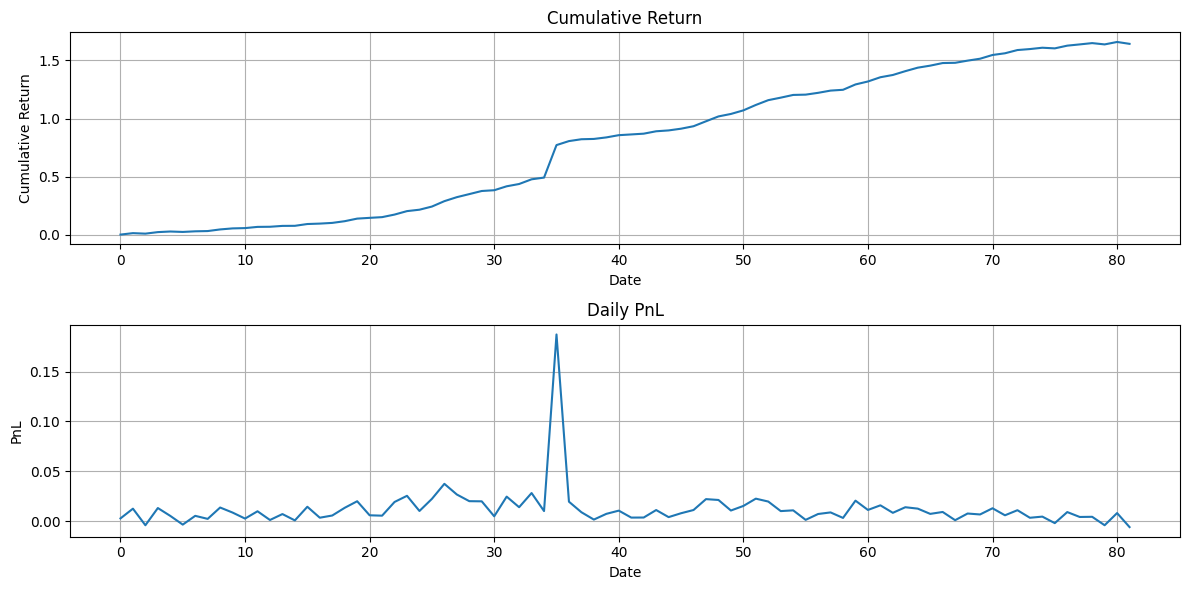

In [123]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(pnl_df['cumulative_return'])
plt.title('Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(pnl_df["pnl"])
plt.title('Daily PnL')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.grid(True)

plt.tight_layout()
plt.show()
